## ![CESI](./photo_livrable/Logo_cesi.png)

# Projet Leyenda
## Livrable 2 - Denoising
|Auteurs|
|---|
|Karim Salhi
|Corentin Devrouete
|Hugo Larose
|Pierre-Alain Tietz

### Importation des librairies

Dans un premier temps nous allons importer toutes les libraires nécessaire à notre débruitage :
- **Keras**, la bibliothèque Keras permet d'interagir avec les algorithmes de réseaux de neurones profonds et d'apprentissage automatique, notamment Tensorflow.
- **Tensorflow**, TensorFlow est un outil open source d'apprentissage automatique développé par Google.
- **Numpy**, NumPy est une bibliothèque pour langage de programmation Python, destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
- **Matplotlib**, est une bibliothèque utilisée pour tracer et visualiser des données à l'aide de graphiques.
- **Scikit-Learn**, est une bibliothèque utilisée pour l'apprentissage automatique et l'analyse de métriques
- **OpenCV** est une bibliothèque utilisée pour du traitement d'images.
- **Tqdm** est une bibliothèque utilisée pour visualiser des progress bar configurables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pathlib
import os, cv2
import tensorflow as tf
from tqdm import tqdm
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from skimage.util import random_noise
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Initialisation des hyperparamètres


Ces paramètres nous servirons tout au long de notre programme d'intelligence artificielle :

>**BATCH_SIZE** : Cette variable est la taille du lot qui définit le nombre d'échantillons qui seront propagés à travers le réseau.
>
>**VALIDATION_SPLIT** : C'est un moyen de prédire l'ajustement d'un modèle à un ensemble de tests hypothétique lorsqu'un ensemble de tests explicite n'est pas disponible
>
>**EPOCHS** : Une époque fait référence à un cycle à travers l'ensemble de données d'entraînement complet.
>
>**NOISE_FACTOR** : C'est le facteur de bruitage qui va définir si notre image va être fortement bruité ou non. 

Ensuite nous definissons le chemin des répertoires vers le jeu de données et nos sauvegarde des modèles.

In [3]:
# Définitions des répertoire 
PATH_MODEL_SAVE = './PATH_MODEL_SAVE'
PATH_DATASET = pathlib.Path("../Dataset2")

NOISE_FACTOR = 0.2
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
BATCH_SIZE = 9
VALIDATION_SPLIT = 0.2

In [4]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
    color_mode='rgb'
)

x_train, _ = iter(dataset_train).next()
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

dataset_test = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
    color_mode='rgb'
)

x_test, _ = iter(dataset_test).next()
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

print(x_train.shape)
print(x_test.shape)

Found 4009 files belonging to 1 classes.
Using 3208 files for training.
Found 4009 files belonging to 1 classes.
Using 801 files for validation.
(9, 256, 256, 3)
(9, 256, 256, 3)


In [5]:
# Définition des jeux de test et validation
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) * NOISE_FACTOR
x_test_noisy = x_test + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) * NOISE_FACTOR

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

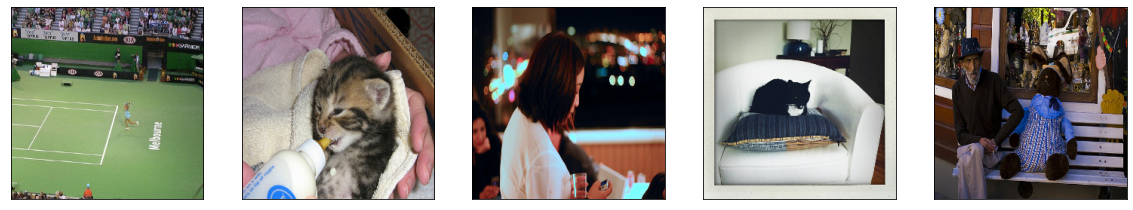

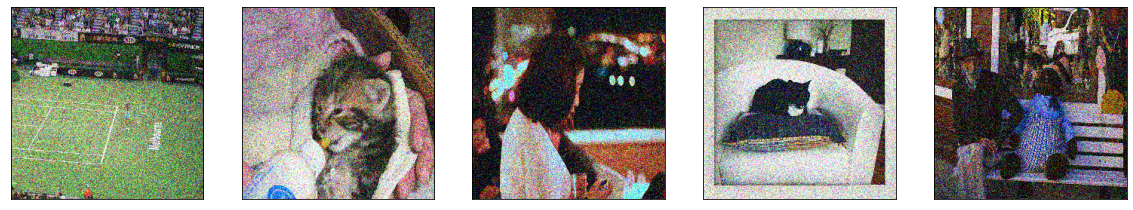

In [6]:
#Affichage d'image
def display_image(X, n, size = 20):
    plt.figure(figsize=(size, size))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

In [7]:
EPOCHS = 500
BATCH_SIZE = 18

### Principe de l'auto-encodeur

Les auto-encodeurs sont des algorithmes d’apprentissage non supervisé à base de réseaux de neurones artificiels, qui permettent de construire une nouvelle représentation d’un jeu de données. Généralement, celle-ci est plus compacte, et présente moins de descripteurs, ce qui permet de réduire la dimensionnalité du jeu de données. L’architecture d’un auto-encodeur est constitué de deux parties : l’encodeur et le décodeur.

L’encodeur est constitué par un ensemble de couches de neurones, qui traitent les données afin de construire de nouvelles représentations dites “encodées”. À leur tour, les couches de neurones du décodeur, reçoivent ces représentations et les traitent afin d’essayer de reconstruire les données de départ. Les différences entre les données reconstruites et les données initiales permettent de mesurer l’erreur commise par l’auto-encodeur. L’entraînement consiste à modifier les paramètres de l’auto-encodeur afin de réduire l’erreur de reconstruction mesurée sur les différents exemples du jeu de données.

La plupart du temps, on ne s’intéresse pas à la dernière couche du décodeur, qui contient uniquement la reconstruction des données initiales, mais plutôt à la nouvelle représentation créée par l’encodeur.

L’architecture la plus simple d’un auto-encodeur est semblable à un perceptron multicouches. Cependant, en fonction des données traitées, on peut utiliser différentes topologies de réseaux de neurones. Par exemple, des couches convolutives afin d’analyser des images ou des couches de neurones récurrentes pour traiter des séries temporelles ou des séquences.

À noter qu’à la différence d’un grand nombre de réseaux de neurones, les auto-encodeurs peuvent être entraînés de manière non-supervisée, ce qui permet d’appliquer ces méthodes à des jeux de données non annotés.

La figure suivante schématise un auto-encodeur simple, dont l’encodeur (encoder) traite des images (inputs), afin de les représenter comme des points dans un espace à deux dimensions (encoded representation), puis décode cette représentation (decoder), afin de retrouver les données de départ (output).

![Autoencoder](./photo_livrable/Autoencoder.png)

In [8]:
inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), name="input")
# ENCODING
# Convolution 1
conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name="conv_1_encoder")(inputs)
pooling1 = MaxPooling2D((2, 2), padding="same", name="pooling_1")(conv1)

# Convolution 2
conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name="conv_2_encoder")(pooling1)
pooling2 = MaxPooling2D((2, 2), padding="same", name="pooling_2")(conv2)

# Convolution 3
conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name="conv_3_encoder")(pooling2)
encode = MaxPooling2D((2, 2), padding="same", name="pooling_3")(conv3)


In [9]:
# DECODING

# Déconvolution 1
conv4 = Conv2D(256, (3, 3),  activation="relu", padding="same")(encode)
upsamp1 = UpSampling2D((2, 2), name="sampling_1")(conv4)
#x = Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_2_decoder")(encode)

# Déconvolution 2
conv5 = Conv2D(128, (3, 3),  activation="relu", padding="same")(upsamp1)
upsamp2 = UpSampling2D((2, 2), name="sampling_2")(conv5)
#x = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_3_decoder")(x)

# Déconvolution 3
conv6 = Conv2D(64, (3, 3),  activation="relu", padding="same")(upsamp2)
upsamp3 = UpSampling2D((2, 2), name="sampling_3")(conv6)
#x = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu', name="conv_4_decoder")(x)
 
# Output    
decode = Conv2D(3, (3, 3),  padding="same", activation="sigmoid", name="output")(upsamp3)

In [10]:
#Définition de l'autoencoder et compilation du modèle 
autoencoder = Model(inputs, decode, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv_1_encoder (Conv2D)     (None, 256, 256, 64)      1792      
                                                                 
 pooling_1 (MaxPooling2D)    (None, 128, 128, 64)      0         
                                                                 
 conv_2_encoder (Conv2D)     (None, 128, 128, 128)     73856     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 64, 64, 128)       0         
                                                                 
 conv_3_encoder (Conv2D)     (None, 64, 64, 256)       295168    
                                                                 
 pooling_3 (MaxPooling2D)    (None, 32, 32, 256)       

In [11]:
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath='./bestmodel.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

In [12]:
#On entraine l'autoencoder
history = autoencoder.fit(x_train_noisy, 
                          x_train, 
                          epochs= EPOCHS, 
                          batch_size = BATCH_SIZE,  
                          validation_data=(x_test_noisy, x_test),
                          callbacks = callbacks_list
                         )

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 0.6925 - accuracy: 0.4221 - val_loss: 0.7690 - val_accuracy: 0.4950
Epoch 2/500
1/1 [==============================] - 3s 3s/step - loss: 0.7080 - accuracy: 0.4441 - val_loss: 0.6931 - val_accuracy: 0.3214
Epoch 3/500
1/1 [==============================] - 4s 4s/step - loss: 0.6852 - accuracy: 0.2171 - val_loss: 0.6898 - val_accuracy: 0.1756
Epoch 4/500
1/1 [==============================] - 3s 3s/step - loss: 0.6766 - accuracy: 0.3392 - val_loss: 0.6912 - val_accuracy: 0.1748
Epoch 5/500
1/1 [==============================] - 3s 3s/step - loss: 0.6557 - accuracy: 0.3403 - val_loss: 0.6931 - val_accuracy: 0.1910
Epoch 6/500
1/1 [==============================] - 4s 4s/step - loss: 0.6202 - accuracy: 0.3383 - val_loss: 0.6617 - val_accuracy: 0.4949
Epoch 7/500
1/1 [==============================] - 3s 3s/step - loss: 0.5799 - accuracy: 0.4434 - val_loss: 0.6454 - val_accuracy: 0.4921
Epoch 8/500
1/1 [=================

1/1 [==============================] - 4s 4s/step - loss: 0.4824 - accuracy: 0.4621 - val_loss: 0.5833 - val_accuracy: 0.3973
Epoch 61/500
1/1 [==============================] - 3s 3s/step - loss: 0.4805 - accuracy: 0.4712 - val_loss: 0.5843 - val_accuracy: 0.3958
Epoch 62/500
1/1 [==============================] - 3s 3s/step - loss: 0.4806 - accuracy: 0.4609 - val_loss: 0.5842 - val_accuracy: 0.3933
Epoch 63/500
1/1 [==============================] - 4s 4s/step - loss: 0.4809 - accuracy: 0.4586 - val_loss: 0.5822 - val_accuracy: 0.3901
Epoch 64/500
1/1 [==============================] - 4s 4s/step - loss: 0.4796 - accuracy: 0.4682 - val_loss: 0.5823 - val_accuracy: 0.3836
Epoch 65/500
1/1 [==============================] - 4s 4s/step - loss: 0.4804 - accuracy: 0.4706 - val_loss: 0.5822 - val_accuracy: 0.3852
Epoch 66/500
1/1 [==============================] - 4s 4s/step - loss: 0.4791 - accuracy: 0.4681 - val_loss: 0.5837 - val_accuracy: 0.3880
Epoch 67/500
1/1 [======================

Epoch 119/500
1/1 [==============================] - 3s 3s/step - loss: 0.4704 - accuracy: 0.5993 - val_loss: 0.5692 - val_accuracy: 0.6790
Epoch 120/500
1/1 [==============================] - 3s 3s/step - loss: 0.4713 - accuracy: 0.6104 - val_loss: 0.5702 - val_accuracy: 0.6534
Epoch 121/500
1/1 [==============================] - 3s 3s/step - loss: 0.4728 - accuracy: 0.5478 - val_loss: 0.5696 - val_accuracy: 0.6556
Epoch 122/500
1/1 [==============================] - 4s 4s/step - loss: 0.4717 - accuracy: 0.6061 - val_loss: 0.5682 - val_accuracy: 0.6379
Epoch 123/500
1/1 [==============================] - 3s 3s/step - loss: 0.4696 - accuracy: 0.5910 - val_loss: 0.5674 - val_accuracy: 0.6778
Epoch 124/500
1/1 [==============================] - 3s 3s/step - loss: 0.4691 - accuracy: 0.6094 - val_loss: 0.5689 - val_accuracy: 0.7022
Epoch 125/500
1/1 [==============================] - 3s 3s/step - loss: 0.4706 - accuracy: 0.6027 - val_loss: 0.5679 - val_accuracy: 0.7018
Epoch 126/500
1/1 [=

1/1 [==============================] - 3s 3s/step - loss: 0.4635 - accuracy: 0.7186 - val_loss: 0.5626 - val_accuracy: 0.8094
Epoch 236/500
1/1 [==============================] - 3s 3s/step - loss: 0.4641 - accuracy: 0.7261 - val_loss: 0.5634 - val_accuracy: 0.8081
Epoch 237/500
1/1 [==============================] - 3s 3s/step - loss: 0.4651 - accuracy: 0.7181 - val_loss: 0.5648 - val_accuracy: 0.8051
Epoch 238/500
1/1 [==============================] - 3s 3s/step - loss: 0.4662 - accuracy: 0.7147 - val_loss: 0.5644 - val_accuracy: 0.8119
Epoch 239/500
1/1 [==============================] - 3s 3s/step - loss: 0.4656 - accuracy: 0.7141 - val_loss: 0.5618 - val_accuracy: 0.8132
Epoch 240/500
1/1 [==============================] - 3s 3s/step - loss: 0.4634 - accuracy: 0.7198 - val_loss: 0.5617 - val_accuracy: 0.8129
Epoch 241/500
1/1 [==============================] - 3s 3s/step - loss: 0.4631 - accuracy: 0.7151 - val_loss: 0.5624 - val_accuracy: 0.8002
Epoch 242/500
1/1 [===============

1/1 [==============================] - 3s 3s/step - loss: 0.4606 - accuracy: 0.7338 - val_loss: 0.5605 - val_accuracy: 0.8289
Epoch 352/500
1/1 [==============================] - 3s 3s/step - loss: 0.4605 - accuracy: 0.7399 - val_loss: 0.5605 - val_accuracy: 0.8156
Epoch 353/500
1/1 [==============================] - 3s 3s/step - loss: 0.4602 - accuracy: 0.7404 - val_loss: 0.5602 - val_accuracy: 0.8211
Epoch 354/500
1/1 [==============================] - 4s 4s/step - loss: 0.4600 - accuracy: 0.7430 - val_loss: 0.5602 - val_accuracy: 0.8260
Epoch 355/500
1/1 [==============================] - 4s 4s/step - loss: 0.4600 - accuracy: 0.7449 - val_loss: 0.5604 - val_accuracy: 0.8116
Epoch 356/500
1/1 [==============================] - 4s 4s/step - loss: 0.4601 - accuracy: 0.7354 - val_loss: 0.5603 - val_accuracy: 0.8237
Epoch 357/500
1/1 [==============================] - 5s 5s/step - loss: 0.4602 - accuracy: 0.7385 - val_loss: 0.5607 - val_accuracy: 0.8211
Epoch 358/500
1/1 [===============

1/1 [==============================] - 3s 3s/step - loss: 0.4588 - accuracy: 0.7413 - val_loss: 0.5601 - val_accuracy: 0.8194
Epoch 468/500
1/1 [==============================] - 3s 3s/step - loss: 0.4586 - accuracy: 0.7475 - val_loss: 0.5602 - val_accuracy: 0.8175
Epoch 469/500
1/1 [==============================] - 3s 3s/step - loss: 0.4588 - accuracy: 0.7429 - val_loss: 0.5604 - val_accuracy: 0.8200
Epoch 470/500
1/1 [==============================] - 3s 3s/step - loss: 0.4586 - accuracy: 0.7502 - val_loss: 0.5609 - val_accuracy: 0.8195
Epoch 471/500
1/1 [==============================] - 3s 3s/step - loss: 0.4586 - accuracy: 0.7455 - val_loss: 0.5602 - val_accuracy: 0.8254
Epoch 472/500
1/1 [==============================] - 3s 3s/step - loss: 0.4585 - accuracy: 0.7508 - val_loss: 0.5602 - val_accuracy: 0.8252
Epoch 473/500
1/1 [==============================] - 3s 3s/step - loss: 0.4586 - accuracy: 0.7442 - val_loss: 0.5600 - val_accuracy: 0.8205
Epoch 474/500
1/1 [===============

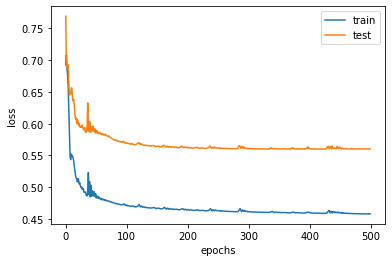

In [13]:
# On affiche les courbes loss du train et test 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel(list(history.history.keys())[0])
plt.show()

# Comparaison des images

Avec le modèle entraîné, nous pouvons maintenant réaliser des prédictions, c'est-à-dire exécuter le processus de denoising par l'auto-encodeur. Nous affichons ainsi des images nettes et les images traitées pour les comparer.

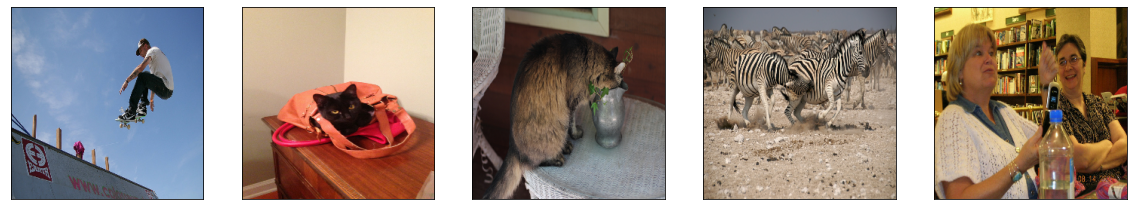

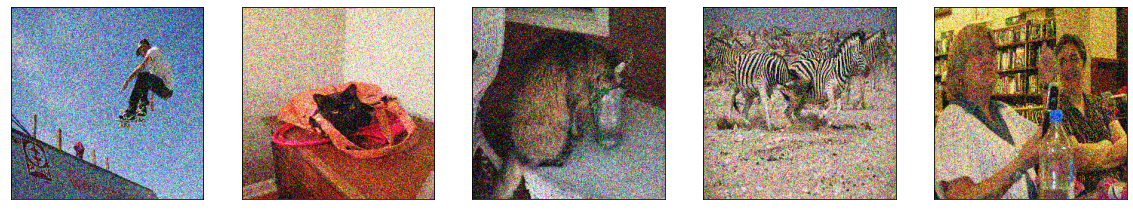

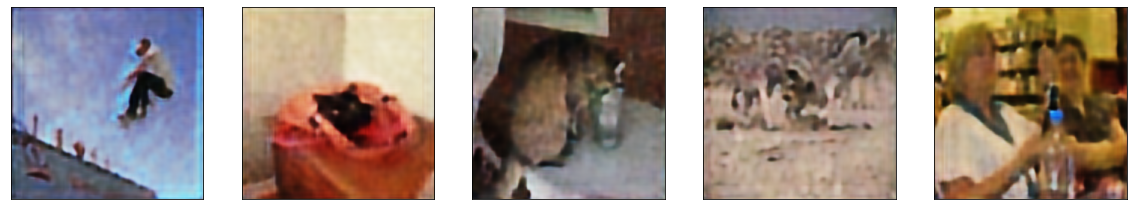

In [14]:
predictions = autoencoder.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

In [15]:
# On sauvegarde le modèle pour le réutiliser
autoencoder.save('PATH_MODEL_SAVE')
model = tf.keras.models.load_model(PATH_MODEL_SAVE)

INFO:tensorflow:Assets written to: PATH_MODEL_SAVE\assets


In [16]:
# On met l'image de test dans le bon format
input_img = PIL.Image.open('./images2.jpg').convert('RGB')
input_img = input_img.resize((256, 256), PIL.Image.ANTIALIAS)
input_img = np.array(input_img, dtype=np.float32)
input_img = input_img.astype('float32')/255
input_img = tf.expand_dims(input_img, axis=0)

FileNotFoundError: [Errno 2] No such file or directory: './images2.jpg'

In [ ]:
# Prédire une version débruité
denoised = model.predict(input_img)
display_image(denoised, n=1)

## Améliorations potentielles

Afin d'améliorer les performances de notre auto-encodeur, plusieurs solutions auraient pu être implémentées :

- Il aurait été intéressant d'utiliser des datasets plus grands, afin d'enrichir les données d'entraînement du modèle et de mieux généraliser le modèle.
- Enfin nous aurions pu réaliser un entraînement plus poussé, en augmentant la quantité d'epochs ou encore le nombre d'étapes par epoch.